------
# **Dementia Patients -- Analysis and Prediction**
### ***Author : Akhilesh Vyas***
### ****Date : August, 2019****



# ***Result Plots***

- <a href='#00'>0. Setup </a>
    - <a href='#00.1'>0.1. Load libraries </a>
    - <a href='#00.2'>0.2. Define paths </a>

- <a href='#01'>1. Data Preparation </a>  
    - <a href='#01.1'>1.1. Read Data </a> 
    - <a href='#01.2'>1.2. Prepare data  </a>
    - <a href='#01.3'>1.3. Prepare target </a>
    - <a href='#01.4'>1.4. Removing Unwanted Features </a>
    
- <a href='#02'>2. Data Analysis</a> 
    - <a href='#02.1'>2.1. Feature </a> 
    - <a href='#02.2'>2.2. Target </a> 
    
- <a href='#03'>3. Data Preparation and Vector Transformation</a>

- <a href='#04'>4. Analysis and Imputing Missing Values </a>

- <a href='#05'>5. Feature Analysis</a> 
    - <a href='#05.1'>5.1. Correlation Matrix</a>
    - <a href='#05.2'>5.2. Feature and target </a>
    - <a href='#05.3'>5.3. Feature Selection Models </a>
    
- <a href='#06'>6.Machine Learning -Classification Model</a> 

# <a id='00'>0. Setup </a>

# <a id='00.1'>0.1 Load libraries </a>

Loading Libraries

In [1]:
import sys
sys.path.insert(1, '../preprocessing/')
import numpy as np
import pickle
import scipy.stats as spstats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from sklearn.datasets.base import Bunch
#from data_transformation_cls import FeatureTransform
from ast import literal_eval
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objects as go

import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from ordered_set import OrderedSet

%matplotlib inline

/Volumes/Vyas-HD/programming/python3Env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# <a id='00.2'>0.2 Define paths </a>

In [2]:
# data_path
# !cp -r ../../../datalcdem/data/optima/dementia_18July/data_notasked/ ../../../datalcdem/data/optima/dementia_18July/data_notasked_mmse_0_30/
#data_path = '../../../datalcdem/data/optima/dementia_03_2020/data_filled_wiiliam/'
#result_path = '../../../datalcdem/data/optima/dementia_03_2020/data_filled_wiiliam/results/'
#optima_path = '../../../datalcdem/data/optima/optima_excel/'

data_path = '../../data/'

In [3]:
# Reading Data

#patients data
patient_df = pd.read_csv(data_path+'patients.csv')
print (patient_df.dtypes)
# change dataType if there is something
for col in patient_df.columns: 
    if 'Date' in col:
        patient_df[col] = pd.to_datetime(patient_df[col]) 
 
patient_df = patient_df[['patient_id','gender', 'smoker', 'education', 'ageAtFirstEpisode', 'apoe']]
patient_df.rename(columns={'ageAtFirstEpisode':'age'}, inplace=True)
patient_df.head(5)

patient_id                   int64  
gender                       object 
dementia                     bool   
smoker                       object 
alcohol                      object 
education                    object 
bmi                          float64
weight                       float64
ageAtFirstEpisode            int64  
ageAtLastEpisode             int64  
malignantComorbidity         object 
systemicComorbidity          object 
cardiovascularComorbidity    bool   
metabolicComorbidity         bool   
infectiousComorbidity        bool   
neoplasticComorbidity        bool   
respiratoryComorbidity       bool   
neurologicalComorbidity      bool   
inflammatoryComorbidity      bool   
apoe                         object 
epDateInicial                object 
mmseInicial                  int64  
mmseInicialDiscretized       object 
epDateFinal                  object 
mmseFinal                    int64  
mmseFinalDiscretized         object 
epDateToSevereData           object 
e

,patient_id,gender,smoker,education,age,apoe
0,1,Male,smoker,medium,71,E3E3
1,14,Female,no_smoker,medium,79,E3E4
2,16,Male,no_smoker,higher,78,E3E4
3,19,Male,smoker,higher,56,E3E4
4,32,Male,no_smoker,higher,72,E3E3


# <a id='1'>1. Data Preparation </a> 

## <a id='01.1'>1.1. Read Data</a>

In [4]:
#Preparation Features from Raw data

# Extracting selected features from Raw data
def rename_columns(col_list):
    d = {}
    for i in col_list:
        if i=='GLOBAL_PATIENT_DB_ID':
            d[i]='patient_id'
        elif 'CAMDEX SCORES: ' in i:
            d[i]=i.replace('CAMDEX SCORES: ', '').replace(' ', '_')
        elif 'CAMDEX ADMINISTRATION 1-12: ' in i:
            d[i]=i.replace('CAMDEX ADMINISTRATION 1-12: ', '').replace(' ', '_')
        elif 'DIAGNOSIS 334-351: ' in i:
            d[i]=i.replace('DIAGNOSIS 334-351: ', '').replace(' ', '_')
        elif 'OPTIMA DIAGNOSES V 2010: ' in i:
            d[i]=i.replace('OPTIMA DIAGNOSES V 2010: ', '').replace(' ', '_')
        elif 'PM INFORMATION: ' in i:
            d[i]=i.replace('PM INFORMATION: ', '').replace(' ', '_')
        else:
            d[i]=i.replace(' ', '_')
    return d


columns_selected = ['GLOBAL_PATIENT_DB_ID', 'EPISODE_DATE', 'CAMDEX SCORES: MINI MENTAL SCORE', 'CLINICAL BACKGROUND: BODY MASS INDEX',  
          'DIAGNOSIS 334-351: ANXIETY/PHOBIC', 'OPTIMA DIAGNOSES V 2010: CERBRO-VASCULAR DISEASE PRESENT', 'DIAGNOSIS 334-351: DEPRESSIVE ILLNESS',
          'OPTIMA DIAGNOSES V 2010: DIAGNOSTIC CODE', 'CAMDEX ADMINISTRATION 1-12: EST OF SEVERITY OF DEPRESSION', 
           'CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA', 'DIAGNOSIS 334-351: PRIMARY PSYCHIATRIC DIAGNOSES', 'OPTIMA DIAGNOSES V 2010: PETERSEN MCI']

# Need to think about other columns eg. dementia, social, sleeping habits, 
df_datarequest = pd.read_excel(data_path+'Optima_Data_Report_Cases_6511_filled.xlsx')
display(df_datarequest.head(1))
df_datarequest_features = df_datarequest[columns_selected]
display(df_datarequest_features.columns)

columns_renamed = rename_columns(df_datarequest_features.columns.tolist())
df_datarequest_features.rename(columns=columns_renamed, inplace=True)
patient_com_treat_fea_raw_df = df_datarequest_features # Need to be changed ------------------------
display(patient_com_treat_fea_raw_df.head(5))
           
# merging
patient_df = patient_com_treat_fea_raw_df.merge(patient_df,how='inner', on=['patient_id'])           
           
# age calculator
patient_df['age'] = patient_df['age'] + patient_df.groupby(by=['patient_id'])['EPISODE_DATE'].transform(lambda x: (x - x.iloc[0])/(np.timedelta64(1, 'D')*365.25))

# saving file
patient_df.to_csv(data_path + 'patient_com_treat_fea_filled_sel_col.csv', index=False)

           

# patient_com_treat_fea_raw_df = patient_com_treat_fea_raw_df.drop_duplicates(subset=['patient_id', 'EPISODE_DATE'])
patient_df.sort_values(by=['patient_id', 'EPISODE_DATE'], inplace=True)

display(patient_df.head(5))


,Unnamed: 0,GLOBAL_PATIENT_DB_ID,STUDY_ID,STUDY,DOD,Age At Episode,GENDER,EPISODE_DATE,EPISODE,CAMDEX ADMINISTRATION 1-12: DATE OF EXAMINATION,CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA,CAMDEX ADMINISTRATION 1-12: EST OF SEVERITY OF DEPRESSION,CAMDEX ADMINISTRATION 1-12: VISUALLY IMPAIRED,CAMDEX ADMINISTRATION 1-12: HARD OF HEARING,CAMDEX ADMINISTRATION 1-12: TOTALLY CARED FOR,CAMDEX ADMINISTRATION 1-12: OTHER SIGNIFICANT IMPAIRMENT,CAMDEX ADMINISTRATION 1-12: OTHER SIGNIFICANT IMPAIRMENT: TEXT,PRESENT STATE 13-46: PRESENT STATE 13-46,PRESENT STATE 13-46: (013) NAME KNOWN,PRESENT STATE 13-46: (014) AGE KNOWN,PRESENT STATE 13-46: (015) DATE OF BIRTH KNOWN,PRESENT STATE 13-46: (016) AGE LEFT SCHOOL,PRESENT STATE 13-46: (017) YEARS IN FURTHER EDUCATION,PRESENT STATE 13-46: (017) YEARS IN FURTHER EDUCATION: TEXT,PRESENT STATE 13-46: (018) LIVING ARRANGEMENTS,PRESENT STATE 13-46: (019) HEADACHE,PRESENT STATE 13-46: (020) DIZZYNESS,PRESENT STATE 13-46: (021) FALLS,PRESENT STATE 13-46: (022) TIA,PRESENT STATE 13-46: (023) FALLS ASLEEP,PRESENT STATE 13-46: (024) WAKEFUL,PRESENT STATE 13-46: (025) WAKES EARLY,PRESENT STATE 13-46: (025) WAKES EARLY: TEXT,PRESENT STATE 13-46: (026) APPETITE CHANGE,PRESENT STATE 13-46: (027) WEIGHT CHANGE,PRESENT STATE 13-46: (027) WEIGHT CHANGE: TEXT,PRESENT STATE 13-46: (028) COPING LESS,PRESENT STATE 13-46: (029) DECISION MAKING DIFFICULT,PRESENT STATE 13-46: (030) PLEASURE LOSS,PRESENT STATE 13-46: (031) ENERGY LOSS,PRESENT STATE 13-46: (032) ALONE PREFERENCE,PRESENT STATE 13-46: (033) CONCENTRATION DIFFICULT,PRESENT STATE 13-46: (034) SLOWED SPEECH,PRESENT STATE 13-46: (035) SLOWED THOUGHT,PRESENT STATE 13-46: (036) FEELING DEPRESSED,PRESENT STATE 13-46: (037) DURATION OF DEPRESSION,PRESENT STATE 13-46: (038) REASON FOR DEPRESSION,PRESENT STATE 13-46: (038) REASON FOR DEPRESSION: TEXT,PRESENT STATE 13-46: (039) DIFFERENT FROM SADNESS,PRESENT STATE 13-46: (040) CHEERS UP,PRESENT STATE 13-46: (041) DIURNAL CHANGE,PRESENT STATE 13-46: (042) BLAMES OTHERS,PRESENT STATE 13-46: (043) WORTHLESS OR GUILTY,PRESENT STATE 13-46: (044) FUTURE FEELINGS,PRESENT STATE 13-46: (045) NOT WORTH LIVING,PRESENT STATE 13-46: (046) SUICIDAL FEELINGS,PRESENT STATE 47-73: PRESENT STATE 47-73,PRESENT STATE 47-73: (047) WORRIES MORE,PRESENT STATE 47-73: (048) IRRITABLE,PRESENT STATE 47-73: (049) ANXIOUS,PRESENT STATE 47-73: (050) PHYSICAL SYMPTOMS,PRESENT STATE 47-73: (051) ANXIOUS SITUATIONS,PRESENT STATE 47-73: (051) ANXIOUS SITUATIONS: TEXT,PRESENT STATE 47-73: (052) PANIC ATTACKS,PRESENT STATE 47-73: (053) DURATION OF PANIC,PRESENT STATE 47-73: (054) MONEY HANDLING DIFFICULT,PRESENT STATE 47-73: (055) HOUSEHOLD TASKS DIFFICULT,PRESENT STATE 47-73: (056) BLADDER CONTROL DIFFICULT,PRESENT STATE 47-73: (057) PHYSICAL PROBLEMS,PRESENT STATE 47-73: (058) MEMORY PROBLEM,PRESENT STATE 47-73: (059) FORGETS OBJECTS,PRESENT STATE 47-73: (060) FORGETS NAMES,PRESENT STATE 47-73: (061) FORGETS WAY,PRESENT STATE 47-73: (062) DURATION OF MEMORY PROBLEMS,PRESENT STATE 47-73: (063) ONSET OF MEMORY PROBLEMS,PRESENT STATE 47-73: (064) CHANGE IN MEMORY PROBLEMS,PRESENT STATE 47-73: (065) REFERS MORE TO THE PAST,PRESENT STATE 47-73: (066) WORD FINDING DIFFICULTY,PRESENT STATE 47-73: (066) WORD FINDING DIFFICULTY: DURATION,PRESENT STATE 47-73: (068) AUDITORY HALLUCINATIONS,PRESENT STATE 47-73: (068) AUDITORY HALLUCINATIONS: DURATION,PRESENT STATE 47-73: (068) AUDITORY HALLUCINATIONS: TEXT,PRESENT STATE 47-73: (069) VISUAL HALLUCINATIONS,PRESENT STATE 47-73: (069) VISUAL HALLUCINATIONS: DURATION,PRESENT STATE 47-73: (069) VISUAL HALLUCINATIONS: TEXT,PRESENT STATE 47-73: (070) WATCHED OR SPIED ON,PRESENT STATE 47-73: (070) WATCHED OR SPIED ON: DURATION,PRESENT STATE 47-73: (071) PASSIVITY FEELINGS,PRESENT STATE 47-73: (071) PASSIVITY FEELINGS: DURATION,PRESENT STATE 47-73: (072) HYPOCHONDRIACAL DELUSIONS,PRESENT STATE 47-73: (072) HYPOCHONDRIACAL DELUSIONS: DURATION,PRESENT STATE 47-73: (073) ILLUSORY INTERFERENCE,PRESENT STATE 47-73: (

Index(['GLOBAL_PATIENT_DB_ID', 'EPISODE_DATE',
       'CAMDEX SCORES: MINI MENTAL SCORE',
       'CLINICAL BACKGROUND: BODY MASS INDEX',
       'DIAGNOSIS 334-351: ANXIETY/PHOBIC',
       'OPTIMA DIAGNOSES V 2010: CERBRO-VASCULAR DISEASE PRESENT',
       'DIAGNOSIS 334-351: DEPRESSIVE ILLNESS',
       'OPTIMA DIAGNOSES V 2010: DIAGNOSTIC CODE',
       'CAMDEX ADMINISTRATION 1-12: EST OF SEVERITY OF DEPRESSION',
       'CAMDEX ADMINISTRATION 1-12: EST SEVERITY OF DEMENTIA',
       'DIAGNOSIS 334-351: PRIMARY PSYCHIATRIC DIAGNOSES',
       'OPTIMA DIAGNOSES V 2010: PETERSEN MCI'],
      dtype='object')

,patient_id,EPISODE_DATE,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI
0,1,1998-01-13,30,28.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0
1,1,2000-01-20,30,NaN,1,0.0,0,0.0,0.0,0.0,9.0,0.0
2,1,2002-02-21,30,NaN,NaN,9.0,NaN,0.0,NaN,NaN,NaN,0.0
3,1,2002-10-28,29,NaN,NaN,9.0,NaN,0.0,NaN,NaN,NaN,0.0
4,1,2004-06-22,30,NaN,NaN,9.0,NaN,0.0,NaN,NaN,NaN,0.0


,patient_id,EPISODE_DATE,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,gender,smoker,education,age,apoe
0,1,1998-01-13,30,28.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,Male,smoker,medium,71.000000,E3E3
1,1,2000-01-20,30,NaN,1,0.0,0,0.0,0.0,0.0,9.0,0.0,Male,smoker,medium,73.019178,E3E3
2,1,2002-02-21,30,NaN,NaN,9.0,NaN,0.0,NaN,NaN,NaN,0.0,Male,smoker,medium,75.109589,E3E3
3,1,2002-10-28,29,NaN,NaN,9.0,NaN,0.0,NaN,NaN,NaN,0.0,Male,smoker,medium,75.791781,E3E3
4,1,2004-06-22,30,NaN,NaN,9.0,NaN,0.0,NaN,NaN,NaN,0.0,Male,smoker,medium,77.443836,E3E3


,patient_id,EPISODE_DATE,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,gender,smoker,education,age,apoe
count,6511.000000,6511,6511.000000,1739.000000,5411.0,6496.000000,5512.0,6478.000000,4611.000000,4611.000000,3437.000000,6490.000000,6511,6510,4432,6511.000000,6477
unique,NaN,3808,NaN,NaN,4.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,2,2,3,NaN,8
top,NaN,2002-02-27 00:00:00,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Female,no_smoker,higher,NaN,E3E3
freq,NaN,11,NaN,NaN,3431.0,NaN,2905.0,NaN,NaN,NaN,NaN,NaN,3314,3524,2398,NaN,3103
first,NaN,1988-02-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-04-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4767.992167,NaN,22.759791,28.845486,NaN,2.514009,NaN,4.191834,1.457601,2.010410,16.692173,5.416333,NaN,NaN,NaN,74.607126,NaN
std,2597.623232,NaN,8.243345,133.856887,NaN,3.717274,NaN,114.247809,2.909199,2.843629,697.762412,4.317444,NaN,NaN,NaN,9.198853,NaN
min,1.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,26.000000,NaN
25%,2598.000000,NaN,19.000000,22.800000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,69.000000,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6511 entries, 0 to 6510
Data columns (total 17 columns):
patient_id                              6511 non-null int64
EPISODE_DATE                            6511 non-null datetime64[ns]
MINI_MENTAL_SCORE                       6511 non-null int64
CLINICAL_BACKGROUND:_BODY_MASS_INDEX    1739 non-null float64
ANXIETY/PHOBIC                          5411 non-null object
CERBRO-VASCULAR_DISEASE_PRESENT         6496 non-null float64
DEPRESSIVE_ILLNESS                      5512 non-null object
DIAGNOSTIC_CODE                         6478 non-null float64
EST_OF_SEVERITY_OF_DEPRESSION           4611 non-null float64
EST_SEVERITY_OF_DEMENTIA                4611 non-null float64
PRIMARY_PSYCHIATRIC_DIAGNOSES           3437 non-null float64
PETERSEN_MCI                            6490 non-null float64
gender                                  6511 non-null object
smoker                                  6510 non-null object
education                 

None

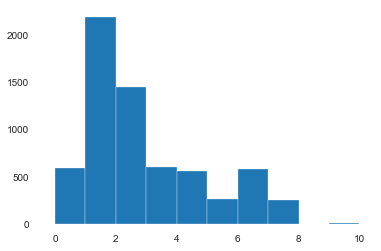

In [5]:
display(patient_df.describe(include='all'))
display(patient_df.info())

tmp_l = []
for i in range(len(patient_df.index)):
    # print("Nan in row ", i , " : " ,  patient_com_treat_fea_raw_df.iloc[i].isnull().sum())
    tmp_l.append(patient_df.iloc[i].isnull().sum())
    
plt.hist(tmp_l)
plt.show()

In [6]:
# find NAN and Notasked and replace them with suitable value
print (patient_df.columns.tolist())
notasked_columns = ['ANXIETY/PHOBIC', 'CERBRO-VASCULAR_DISEASE_PRESENT', 'DEPRESSIVE_ILLNESS','EST_OF_SEVERITY_OF_DEPRESSION', 'EST_SEVERITY_OF_DEMENTIA', 
                    'PRIMARY_PSYCHIATRIC_DIAGNOSES']
print ('total nan values %: ', 100*patient_df.isna().sum().sum()/patient_df.size)
patient_df.loc[:, notasked_columns] =  patient_df.loc[:, notasked_columns].replace([9], [np.nan])
print ('total nan values % after considering notasked: ', 100*patient_df.isna().sum().sum()/patient_df.size)
display(patient_df.isna().sum())
notasked_columns.append('DIAGNOSTIC_CODE')
notasked_columns.append('education')
patient_df.loc[:, notasked_columns] = patient_df.groupby(by=['patient_id'])[notasked_columns].transform(lambda x: x.fillna(method='pad'))
patient_df.loc[:, ['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']] = patient_df.groupby(by=['patient_id'])[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].transform(lambda x: x.interpolate())
patient_df.loc[:, ['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']] = patient_df.groupby(by=['patient_id'])[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].transform(lambda x: x.fillna(method='pad'))
print ('total nan values % after filling : ', 100*patient_df.isna().sum().sum()/patient_df.size)
display(patient_df.isna().sum())

['patient_id', 'EPISODE_DATE', 'MINI_MENTAL_SCORE', 'CLINICAL_BACKGROUND:_BODY_MASS_INDEX', 'ANXIETY/PHOBIC', 'CERBRO-VASCULAR_DISEASE_PRESENT', 'DEPRESSIVE_ILLNESS', 'DIAGNOSTIC_CODE', 'EST_OF_SEVERITY_OF_DEPRESSION', 'EST_SEVERITY_OF_DEMENTIA', 'PRIMARY_PSYCHIATRIC_DIAGNOSES', 'PETERSEN_MCI', 'gender', 'smoker', 'education', 'age', 'apoe']
total nan values %:  14.390127115198714
total nan values % after considering notasked:  18.28398998979103


patient_id                              0   
EPISODE_DATE                            0   
MINI_MENTAL_SCORE                       0   
CLINICAL_BACKGROUND:_BODY_MASS_INDEX    4772
ANXIETY/PHOBIC                          1141
CERBRO-VASCULAR_DISEASE_PRESENT         1419
DEPRESSIVE_ILLNESS                      1016
DIAGNOSTIC_CODE                         33  
EST_OF_SEVERITY_OF_DEPRESSION           2464
EST_SEVERITY_OF_DEMENTIA                2451
PRIMARY_PSYCHIATRIC_DIAGNOSES           4807
PETERSEN_MCI                            21  
gender                                  0   
smoker                                  1   
education                               2079
age                                     0   
apoe                                    34  
dtype: int64

total nan values % after filling :  6.119959886888252


patient_id                              0   
EPISODE_DATE                            0   
MINI_MENTAL_SCORE                       0   
CLINICAL_BACKGROUND:_BODY_MASS_INDEX    2269
ANXIETY/PHOBIC                          2   
CERBRO-VASCULAR_DISEASE_PRESENT         240 
DEPRESSIVE_ILLNESS                      2   
DIAGNOSTIC_CODE                         3   
EST_OF_SEVERITY_OF_DEPRESSION           276 
EST_SEVERITY_OF_DEMENTIA                264 
PRIMARY_PSYCHIATRIC_DIAGNOSES           1583
PETERSEN_MCI                            21  
gender                                  0   
smoker                                  1   
education                               2079
age                                     0   
apoe                                    34  
dtype: int64

In [7]:
# Label of patients:
misdiagnosed_df = pd.read_csv(data_path+'misdiagnosed.csv')
display(misdiagnosed_df.head(5))

misdiagnosed_df['EPISODE_DATE'] = pd.to_datetime(misdiagnosed_df['EPISODE_DATE'])

#Merge Patient_df
patient_df = patient_df.merge(misdiagnosed_df[['patient_id', 'EPISODE_DATE', 'Misdiagnosed','Misdiagnosed1']], how='left', on=['patient_id', 'EPISODE_DATE'])
display(patient_df.head(5))

,patient_id,EPISODE_DATE,PETERSEN_MCI,MINI_MENTAL_SCORE,PSYCHIATRIC,AD_STATUS,MINI_MENTAL_SCORE_CATEGORY,lineNumber,durations(years),MINI_MENTAL_SCORE_CATEGORY(+MCI),State_Update(years),MMSE_Change,Misdiagnosed,Misdiagnosed1
0,1,1998-01-13,0.0,30.0,0.0,0.0,Normal,1,0.000000,Normal,NaN,NaN,UNKNOWN,UNKNOWN
1,1,2000-01-20,0.0,30.0,9.0,0.0,Normal,2,2.019178,Normal,2.019178,0.0,UNKNOWN,UNKNOWN
2,1,2002-02-21,0.0,30.0,NaN,0.0,Normal,3,4.109589,Normal,2.090411,0.0,UNKNOWN,UNKNOWN
3,1,2002-10-28,0.0,29.0,NaN,0.0,Normal,4,4.791781,Normal,0.682192,-1.0,UNKNOWN,UNKNOWN
4,1,2004-06-22,0.0,30.0,NaN,0.0,Normal,5,6.443836,Normal,1.652055,1.0,UNKNOWN,UNKNOWN


,patient_id,EPISODE_DATE,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,gender,smoker,education,age,apoe,Misdiagnosed,Misdiagnosed1
0,1,1998-01-13,30,28.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,Male,smoker,medium,71.000000,E3E3,UNKNOWN,UNKNOWN
1,1,2000-01-20,30,28.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,Male,smoker,medium,73.019178,E3E3,UNKNOWN,UNKNOWN
2,1,2002-02-21,30,28.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,Male,smoker,medium,75.109589,E3E3,UNKNOWN,UNKNOWN
3,1,2002-10-28,29,28.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,Male,smoker,medium,75.791781,E3E3,UNKNOWN,UNKNOWN
4,1,2004-06-22,30,28.0,1,0.0,0,0.0,0.0,0.0,0.0,0.0,Male,smoker,medium,77.443836,E3E3,UNKNOWN,UNKNOWN


In [8]:
patient_df.to_csv(data_path+'patient_df.csv', index=False)

In [9]:
patient_df = pd.read_csv(data_path+'patient_df.csv')
patient_df['EPISODE_DATE'] = pd.to_datetime(patient_df['EPISODE_DATE'])

In [10]:
# duration and previous mini mental score state
patient_df['durations(years)'] = patient_df.groupby(by='patient_id')['EPISODE_DATE'].transform(lambda x: (x - x.iloc[0])/(np.timedelta64(1, 'D')*365.25))
patient_df['MINI_MENTAL_SCORE_PRE'] = patient_df.groupby(by='patient_id')['MINI_MENTAL_SCORE'].transform(lambda x: x.shift(+1))

In [11]:
patient_df[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].describe() # Out of Range values

,CLINICAL_BACKGROUND:_BODY_MASS_INDEX
count,4242.000000
mean,27.032956
std,85.796276
min,0.000000
25%,22.800000
50%,25.300000
75%,28.100000
max,5600.000000


In [12]:
patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX'][(patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']>54) | (patient_df['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']<8)]=np.nan

In [13]:
patient_df[['CLINICAL_BACKGROUND:_BODY_MASS_INDEX']].describe()

,CLINICAL_BACKGROUND:_BODY_MASS_INDEX
count,4201.000000
mean,25.740199
std,4.087311
min,9.350000
25%,22.900000
50%,25.300000
75%,28.100000
max,52.100000


In [14]:
# drop unnecessary columns
# patient_df.drop(columns=['patient_id', 'EPISODE_DATE'], inplace=True)

In [15]:
# drop rows where Misdiagnosed cases are invalid
patient_df = patient_df.dropna(subset=['MINI_MENTAL_SCORE_PRE'], axis=0 )


In [16]:
patient_df['gender'].unique(), patient_df['smoker'].unique(), patient_df['education'].unique(), patient_df['apoe'].unique(), patient_df['Misdiagnosed1'].unique(), patient_df['Misdiagnosed'].unique()

(array(['Male', 'Female'], dtype=object),
 array(['smoker', 'no_smoker'], dtype=object),
 array(['medium', 'higher', nan, 'basic'], dtype=object),
 array(['E3E3', 'E3E4', 'E2E3', 'E2E4', 'E4E4', 'TBD', nan, 'E2E2',
        '_E3E3'], dtype=object),
 array(['UNKNOWN', 'NO', 'YES'], dtype=object),
 array(['UNKNOWN', 'NO', 'YES'], dtype=object))

In [17]:
# encoding of categorial features
patient_df.replace(['smoker', 'no_smoker'],[1, 0], inplace=True)
patient_df.replace(['medium', 'higher','basic'],[1, 2, 0], inplace=True)
patient_df.replace(['NO', 'YES', 'UNKNOWN'],[0, 1, 2], inplace=True)
patient_df = pd.get_dummies(patient_df, columns=['gender', 'apoe'])
patient_df.replace(['mixed mitral & Aortic Valve disease', 'Bilateral knee replacements'],[np.nan, np.nan], inplace=True)

In [18]:
# Misdiagnosed Criteria
patient_df = patient_df[patient_df['Misdiagnosed']<2]
patient_df = patient_df.astype({col: str('float64') for col, dtype in zip (patient_df.columns.tolist(), patient_df.dtypes.tolist()) if 'int' in str(dtype) or str(dtype)=='object'})
patient_df.describe()

,patient_id,MINI_MENTAL_SCORE,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,PETERSEN_MCI,smoker,education,age,Misdiagnosed,Misdiagnosed1,durations(years),MINI_MENTAL_SCORE_PRE,gender_Female,gender_Male,apoe_E2E2,apoe_E2E3,apoe_E2E4,apoe_E3E3,apoe_E3E4,apoe_E4E4,apoe_TBD,apoe__E3E3
count,1104.000000,1104.000000,935.000000,1104.000000,1104.000000,1104.000000,1104.000000,1077.000000,1074.000000,684.000000,1101.000000,1104.000000,777.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.000000,1104.0,1104.0
mean,4439.532609,23.672101,25.990378,0.428442,1.594203,0.473732,10.660145,0.345404,0.777467,0.614035,1.366939,0.468297,1.553411,77.246454,0.021739,0.120471,5.095186,24.644928,0.422101,0.577899,0.007246,0.058877,0.040761,0.416667,0.388587,0.076993,0.0,0.0
std,2819.778798,5.622718,4.725330,0.495077,2.321449,0.499536,276.678608,0.634736,0.908598,0.487179,2.706181,0.499220,0.537311,8.741480,0.145897,0.325659,4.220771,4.728035,0.494118,0.494118,0.084855,0.235501,0.197825,0.493230,0.487650,0.266701,0.0,0.0
min,94.000000,2.000000,10.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.509589,0.000000,0.000000,0.342466,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,1910.000000,21.000000,23.025000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,71.263699,0.000000,0.000000,1.975342,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,4188.000000,25.000000,25.200000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,78.098630,0.000000,0.000000,3.987671,26.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,7153.000000,28.000000,28.400000,1.000000,2.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,84.022603,0.000000,0.000000,7.009589,28.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,0.0
max,8754.000000,30.000000,52.100000,1.000000,8.000000,1.000000,9195.000000,3.000000,4.000000,1.000000,9.000000,1.000000,2.000000,96.646575,1.000000,1.000000,24.484932,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0


In [19]:
patient_df_X = patient_df.drop(columns=['patient_id', 'EPISODE_DATE', 'Misdiagnosed1', 'MINI_MENTAL_SCORE', 'PETERSEN_MCI', 'Misdiagnosed'])
patient_df_y_cat = patient_df['Misdiagnosed1']
patient_df_y_cat_s = patient_df['Misdiagnosed']
patient_df_y_real = patient_df['MINI_MENTAL_SCORE']

In [20]:
print (patient_df_X.shape, patient_df_y_cat.shape, patient_df_y_cat_s.shape, patient_df_y_real.shape)
patient_df_X.isna().sum()

(1104, 23) (1104,) (1104,) (1104,)


CLINICAL_BACKGROUND:_BODY_MASS_INDEX    169
ANXIETY/PHOBIC                          0  
CERBRO-VASCULAR_DISEASE_PRESENT         0  
DEPRESSIVE_ILLNESS                      0  
DIAGNOSTIC_CODE                         0  
EST_OF_SEVERITY_OF_DEPRESSION           27 
EST_SEVERITY_OF_DEMENTIA                30 
PRIMARY_PSYCHIATRIC_DIAGNOSES           420
smoker                                  0  
education                               327
age                                     0  
durations(years)                        0  
MINI_MENTAL_SCORE_PRE                   0  
gender_Female                           0  
gender_Male                             0  
apoe_E2E2                               0  
apoe_E2E3                               0  
apoe_E2E4                               0  
apoe_E3E3                               0  
apoe_E3E4                               0  
apoe_E4E4                               0  
apoe_TBD                                0  
apoe__E3E3                      

In [21]:
# Imputing missing values

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor

simple_imputer =  SimpleImputer(strategy='mean')  # Needs to modify
data_p_s = simple_imputer.fit_transform(patient_df_X)
print (data_p_s.shape, np.count_nonzero(np.isnan(data_p_s)))

'''iterative_imputer =  IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators=10, random_state=0))
data_p_e = iterative_imputer.fit_transform(patient_df_X)
print (data_p_e.shape, np.count_nonzero(np.isnan(data_p_e)))'''

(1104, 23) 0


'iterative_imputer =  IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators=10, random_state=0))\ndata_p_e = iterative_imputer.fit_transform(patient_df_X)\nprint (data_p_e.shape, np.count_nonzero(np.isnan(data_p_e)))'

In [ ]:
# RFECV

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler


X = StandardScaler().fit_transform(data_p_s)
X, y = X, patient_df_y_cat

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X, y)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig(result_path + 'RFECV_kerlinear', dpi=120, pad_inch=20)
plt.show()

In [ ]:
patient_df_y_cat.values

In [22]:
# outliers detection

from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(min_samples = 10, eps = 14)
clusters = outlier_detection.fit_predict(data_p_s)
list(clusters).count(-1)


count = 0
for x, y in zip(clusters.tolist(), patient_df_y_cat.values):
    # print (x,y)
    if x==-1 and y==1:
        count = count+1
print (count)

from sklearn.ensemble import IsolationForest
import numpy as np


clf = IsolationForest(max_samples='auto', random_state = 1, contamination= 'auto')
preds = clf.fit_predict(data_p_s)
preds

count = 0
for x, y in zip(preds, patient_df_y_cat.values):
    # print (x,y)
    if x==-1 and y==1:
        count = count+1
print (count)


0
52


In [23]:
sum(preds==-1),sum(patient_df_y_cat==1),  preds.shape #432/5483, 133/5483, 52/133

(432, 133, (1104,))

In [ ]:
# outliers detection

from sklearn.cluster import DBSCAN

outlier_detection = DBSCAN(min_samples = 10, eps = 14)
clusters = outlier_detection.fit_predict(data_p_s)
list(clusters).count(-1)


count = 0
for x, y in zip(clusters.tolist(), patient_df_y_cat_s.values):
    # print (x,y)
    if x==-1 and y==1:
        count = count+1
print (count)

from sklearn.ensemble import IsolationForest
import numpy as np


clf = IsolationForest(max_samples='auto', random_state = 1, contamination= 'auto')
preds = clf.fit_predict(data_p_s)
preds

count = 0
for x, y in zip(preds, patient_df_y_cat_s.values):
    # print (x,y)
    if x==-1 and y==1:
        count = count+1
print (count)


In [ ]:
sum(preds==-1), sum(patient_df_y_cat_s==1), preds.shape #432/5483, 24/5483, 17/24

In [ ]:
patient_df_X.shape, patient_df_y_cat.shape, patient_df_y_cat_s.shape, patient_df_y_real.shape

In [24]:
# training data
patient_df_X_fill_data = pd.DataFrame(data=data_p_s, columns=patient_df_X.columns, index=patient_df_X.index)

patient_df_X_train, patient_df_y_train = patient_df_X_fill_data[patient_df_y_cat==0], patient_df_y_real[patient_df_y_cat==0]
patient_df_X_test, patient_df_y_test= patient_df_X_fill_data[patient_df_y_cat==1], patient_df_y_real[patient_df_y_cat==1]

patient_df_X_s_train, patient_df_y_s_train = patient_df_X_fill_data[patient_df_y_cat_s==0], patient_df_y_real[patient_df_y_cat_s==0]
patient_df_X_s_test, patient_df_y_s_test= patient_df_X_fill_data[patient_df_y_cat_s==1], patient_df_y_real[patient_df_y_cat_s==1]


In [ ]:
patient_df_X_train.to_csv(data_path+'X_train.csv', index=False)
patient_df_y_train.to_csv(data_path+'y_train.csv', index=False)
patient_df_X_test.to_csv(data_path+'X_test.csv', index=False)
patient_df_y_test.to_csv(data_path+'y_test.csv', index=False)

In [25]:
patient_df_X_train.shape, patient_df_y_train.shape, patient_df_X_test.shape, patient_df_y_test.shape

((971, 23), (971,), (133, 23), (133,))

In [26]:
patient_df_X_s_train.shape, patient_df_y_s_train.shape, patient_df_X_s_test.shape, patient_df_y_s_test.shape

((1080, 23), (1080,), (24, 23), (24,))

In [ ]:
# Correlation matrix
plt.figure(figsize=(25,13))
hm = sns.heatmap(patient_df_X_fill_data.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=patient_df_X_fill_data.columns, xticklabels=patient_df_X_fill_data.columns)
plt.show()

In [27]:
X_train, y_train, X_test, y_test = patient_df_X_train.values, patient_df_y_train.values.reshape(-1, 1),patient_df_X_test.values, patient_df_y_test.values.reshape(-1,1)

X_s_train, y_s_train, X_s_test, y_s_test = patient_df_X_s_train.values, patient_df_y_s_train.values.reshape(-1, 1),patient_df_X_s_test.values, patient_df_y_s_test.values.reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm)
predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)
plt.figure(figsize=(15,8))
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(predictions, label = 'predict')
plt.show()

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
clf_pred=clf.predict(X_test)
clf_pred= clf_pred.reshape(-1,1)


plt.figure(figsize=(15,8))
plt.scatter(y_test,clf_pred, c= 'brown')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(clf_pred, label = 'predict')
plt.show()

print('MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(dtr_pred, label = 'predict')
plt.show()

print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)
svr_pred= svr_pred.reshape(-1,1)

plt.figure(figsize=(15,8))
plt.scatter(y_test,svr_pred, c='red')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(svr_pred, label = 'predict')
plt.show()

print('MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('MSE:', metrics.mean_squared_error(y_test, svr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

rfr = RandomForestRegressor(n_estimators = 500, random_state = 0)
rfr.fit(X_train, y_train)
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(rfr_pred, label = 'predict')
plt.show()


print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))
print('Score:',rfr.score(X_test, y_test))


In [ ]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.01, n_estimators=3000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(X_train,y_train)
lgb_pred = model_lgb.predict(X_test)
lgb_pred = lgb_pred.reshape(-1,1)

plt.figure(figsize=(15,8))
plt.scatter(y_test,lgb_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(lgb_pred, label = 'predict')
plt.show()

print('MAE:', metrics.mean_absolute_error(y_test, lgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, lgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgb_pred)))


In [28]:
# Random Forest Classfier

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import classification_report
# patient_df_X_fill_data[patient_df_y_cat==0]
X, y = patient_df_X_fill_data, patient_df_y_cat
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto')
data_p_s, target_p_s = smote.fit_sample(patient_df_X_fill_data, patient_df_y_cat)
print (data_p_s.shape, target_p_s.shape)
# patient_df_X_fill_data[patient_df_y_cat==0]
X, y = data_p_s,  target_p_s
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

from collections import Counter
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(patient_df_X_fill_data, patient_df_y_cat)
print(sorted(Counter(y_resampled).items()))
X, y = X_resampled,  y_resampled
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(patient_df_X_fill_data, patient_df_y_cat)
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

/Volumes/Vyas-HD/programming/python3Env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



{'fit_time': array([1.09000397, 0.30060482, 0.31235218, 0.20148396, 0.2186172 ]), 'score_time': array([0.01830912, 0.02303696, 0.01641893, 0.01970792, 0.0157299 ]), 'test_recall_macro': array([0.5       , 0.51384116, 0.59096984, 0.48969072, 0.51407613]), 'test_precision_macro': array([0.44117647, 0.53138528, 0.60883965, 0.43778802, 0.60906298]), 'test_f1_macro': array([0.46875   , 0.51055237, 0.59832788, 0.4622871 , 0.50163604]), 'test_accuracy': array([0.88235294, 0.84615385, 0.84162896, 0.85972851, 0.87727273])}
              precision    recall  f1-score   support

          NO       0.89      0.98      0.93       971
         YES       0.29      0.08      0.12       133

    accuracy                           0.87      1104
   macro avg       0.59      0.53      0.52      1104
weighted avg       0.81      0.87      0.83      1104

(1942, 23) (1942,)
{'fit_time': array([0.26555395, 0.2531321 , 0.3201859 , 0.24981999, 0.27119493]), 'score_time': array([0.01849103, 0.01803684, 0.02786

In [ ]:
# Random Forest Classfier

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import classification_report
# patient_df_X_fill_data[patient_df_y_cat==0]
X, y = patient_df_X_fill_data, patient_df_y_cat_s
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto')
data_p_s, target_p_s = smote.fit_sample(patient_df_X_fill_data, patient_df_y_cat_s)
print (data_p_s.shape, target_p_s.shape)
# patient_df_X_fill_data[patient_df_y_cat==0]
X, y = data_p_s,  target_p_s
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

from collections import Counter
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(patient_df_X_fill_data, patient_df_y_cat_s)
print(sorted(Counter(y_resampled).items()))
X, y = X_resampled,  y_resampled
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(patient_df_X_fill_data, patient_df_y_cat_s)
clf = RandomForestClassifier(n_estimators=100)
print (cross_validate(clf, X, y, scoring=['recall_macro', 'precision_macro', 'f1_macro', 'accuracy'], cv=5) )
y_pred = cross_val_predict(clf,X, y, cv=5 )
print(classification_report(y, y_pred, target_names=['NO','YES']))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

import time
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}


def plot_regression_results(ax, y_true, y_pred, y_test, y_test_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2, c='g')
    ax.scatter(y_test, y_test_pred, alpha=0.2, c='m')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Y_True')
    ax.set_ylabel('Y_Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    # title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    title = title
    ax.set_title(title)



'''estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Lasso', LassoCV()),
    ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))
]'''

estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('SVR', SVR(kernel = 'rbf')),
    ('Decision Tree', DecisionTreeRegressor(random_state = 100)),
    ('Gradient Boosting', GradientBoostingRegressor(**params))
]



# stacking_regressor = StackingRegressor(
#    estimators=estimators, final_estimator=RidgeCV()
#)



X, y = X_train, y_train

print(X.shape, y.shape, y_test.shape, X_test.shape)

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    if name=='SVR':
        sc_X = StandardScaler()
        sc_y = StandardScaler()
        X = sc_X.fit_transform(X)
        X_test = sc_X.fit_transform(X_test)
        y = sc_X.fit_transform(y)
        y_test = sc_y.fit_transform(y_test)
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0).reshape(-1,1)
    
    est.fit(X,y)
    y_test_pred = est.predict(X_test).reshape(-1,1)
    
    print(y_pred.shape, y_test_pred.shape)

    plot_regression_results(
        ax, y, y_pred, y_test, y_test_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$' + '\n' + r'$R^2TEST={:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error']),
                est.score(X_test, y_test)),
        elapsed_time)

plt.suptitle('Predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [29]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
print(regr.feature_importances_)
y_pred = regr.predict(X_test)
#print(regr.predict(X_test))
print (regr.score(X_test, y_test))
print (regr.score(X_train, y_train))

X_y_test = np.append(X_test, y_pred.reshape(-1,1), axis=1)
print (X_test.shape, y_test.shape, X_y_test.shape)
df_X_y_test = pd.DataFrame(data=X_y_test, columns=patient_df_X_fill_data.columns.tolist()+['MMSE_Predicted'])
df_X_y_test.head(5)

/Volumes/Vyas-HD/programming/python3Env/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.26419746e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99273580e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
-1.4842037879995535
0.7355378194586013
(133, 23) (133, 1) (133, 24)


,CLINICAL_BACKGROUND:_BODY_MASS_INDEX,ANXIETY/PHOBIC,CERBRO-VASCULAR_DISEASE_PRESENT,DEPRESSIVE_ILLNESS,DIAGNOSTIC_CODE,EST_OF_SEVERITY_OF_DEPRESSION,EST_SEVERITY_OF_DEMENTIA,PRIMARY_PSYCHIATRIC_DIAGNOSES,smoker,education,age,durations(years),MINI_MENTAL_SCORE_PRE,gender_Female,gender_Male,apoe_E2E2,apoe_E2E3,apoe_E2E4,apoe_E3E3,apoe_E3E4,apoe_E4E4,apoe_TBD,apoe__E3E3,MMSE_Predicted
0,31.5,0.0,8.0,0.0,0.1,0.0,0.0,0.000000,1.0,1.553411,81.402740,6.402740,27.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26.811105
1,33.4,0.0,2.0,0.0,2.0,0.0,1.0,0.614035,1.0,2.000000,80.158904,2.158904,23.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,21.877083
2,33.4,0.0,2.0,1.0,2.0,0.0,1.0,0.614035,1.0,2.000000,82.043836,4.043836,20.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18.622153
3,19.1,1.0,0.0,0.0,3.0,0.0,1.0,1.000000,0.0,2.000000,61.016438,2.016438,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,24.126206
4,19.1,0.0,0.0,0.0,3.0,0.0,1.0,1.000000,0.0,2.000000,61.994521,2.994521,27.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26.778176


In [30]:
patient_df_tmp = patient_df[['patient_id', 'EPISODE_DATE', 'DIAGNOSTIC_CODE', 'smoker', 'gender_Male', 'age', 'durations(years)', 'MINI_MENTAL_SCORE_PRE', ]]
df_X_y_test_tmp = df_X_y_test[['smoker', 'gender_Male', 'DIAGNOSTIC_CODE', 'age', 'durations(years)', 'MINI_MENTAL_SCORE_PRE', 'MMSE_Predicted']]
p_tmp = patient_df_tmp.merge(df_X_y_test_tmp)
print (patient_df.shape, df_X_y_test_tmp.shape, p_tmp.shape)
print (p_tmp.head(5))

'''p_tmp = patient_df.merge(df_X_y_test)
print (patient_df.shape, df_X_y_test.shape, p_tmp.shape)
p_tmp.head(5)'''

(1104, 29) (133, 7) (133, 9)
   patient_id EPISODE_DATE  DIAGNOSTIC_CODE  smoker  gender_Male        age  \
0  94.0       2004-09-23    0.1              1.0     1.0          81.402740   
1  169.0      2003-04-07    2.0              1.0     1.0          80.158904   
2  169.0      2005-02-23    2.0              1.0     1.0          82.043836   
3  410.0      2002-06-25    3.0              0.0     0.0          61.016438   
4  410.0      2003-06-17    3.0              0.0     0.0          61.994521   

   durations(years)  MINI_MENTAL_SCORE_PRE  MMSE_Predicted  
0  6.402740          27.0                   26.811105       
1  2.158904          23.0                   21.877083       
2  4.043836          20.0                   18.622153       
3  2.016438          26.0                   24.126206       
4  2.994521          27.0                   26.778176       


'p_tmp = patient_df.merge(df_X_y_test)\nprint (patient_df.shape, df_X_y_test.shape, p_tmp.shape)\np_tmp.head(5)'

In [31]:
# Compare it with Predicted MMSE Scores and True MMSE values
patient_df_misdiag = pd.read_csv(data_path+'misdiagnosed.csv')
patient_df_misdiag['EPISODE_DATE'] = pd.to_datetime(patient_df_misdiag['EPISODE_DATE'])
patient_df_misdiag.head(5)

patient_df_misdiag_predmis = patient_df_misdiag.merge(p_tmp[['patient_id', 'EPISODE_DATE', 'MMSE_Predicted']], how='outer', on=['patient_id', 'EPISODE_DATE'])
patient_df_misdiag_predmis.head(5)
display(patient_df_misdiag_predmis.isna().sum())

index_MMSE_Predicted = patient_df_misdiag_predmis['MMSE_Predicted'].notnull()
patient_df_misdiag_predmis['MMSE_Predicted'] = patient_df_misdiag_predmis['MMSE_Predicted'].fillna(patient_df_misdiag_predmis['MINI_MENTAL_SCORE'])

print (sum(patient_df_misdiag_predmis['MMSE_Predicted']!=patient_df_misdiag_predmis['MINI_MENTAL_SCORE']))

# find Misdiagnosed

def find_misdiagonsed1():
    k = 0
    l_misdiagno = []
    for pat_id in patient_df_misdiag_predmis['patient_id'].unique():
        tmp_df = patient_df_misdiag_predmis[['PETERSEN_MCI', 'AD_STATUS', 'MMSE_Predicted', 'durations(years)']][patient_df_misdiag_predmis['patient_id']==pat_id]
        flag = False
        mms_val = 0.0
        dur_val = 0.0
        for i, row in tmp_df.iterrows():
            if (row[0]==1.0 or row[1]== 1.0) and flag==False:
                l_misdiagno.append('UNKNOWN')
                mms_val = row[2]
                dur_val = row[3]
                flag = True
            elif (flag==True):
                if (row[2]-mms_val>5.0) and (row[3]-dur_val<=1.0) or\
                   (row[2]-mms_val>3.0) and ((row[3]-dur_val<2.0 and row[3]-dur_val>1.0)) or\
                   (row[2]-mms_val>0.0) and (row[3]-dur_val>=2.0):
                    l_misdiagno.append('YES')
                else:
                    l_misdiagno.append('NO')
            else:
                l_misdiagno.append('UNKNOWN')
    
    return l_misdiagno
                
 

print (len(find_misdiagonsed1()))
patient_df_misdiag_predmis['Misdiagnosed_Predicted'] = find_misdiagonsed1()

c2=patient_df_misdiag_predmis['Misdiagnosed1']!=patient_df_misdiag_predmis['Misdiagnosed_Predicted']
misdiagnosed1_true_pred= patient_df_misdiag_predmis[index_MMSE_Predicted][['Misdiagnosed1', 'Misdiagnosed_Predicted']].replace(['NO', 'YES'], [0,1])

from sklearn.metrics import classification_report
print(classification_report(misdiagnosed1_true_pred.Misdiagnosed_Predicted, misdiagnosed1_true_pred.Misdiagnosed1, target_names=['NO', 'YES']))


patient_id                          0   
EPISODE_DATE                        0   
PETERSEN_MCI                        22  
MINI_MENTAL_SCORE                   0   
PSYCHIATRIC                         3074
AD_STATUS                           22  
MINI_MENTAL_SCORE_CATEGORY          0   
lineNumber                          0   
durations(years)                    0   
MINI_MENTAL_SCORE_CATEGORY(+MCI)    0   
State_Update(years)                 1028
MMSE_Change                         1028
Misdiagnosed                        0   
Misdiagnosed1                       0   
MMSE_Predicted                      6378
dtype: int64

133
6511
              precision    recall  f1-score   support

          NO       0.00      0.00      0.00        85
         YES       0.36      1.00      0.53        48

    accuracy                           0.36       133
   macro avg       0.18      0.50      0.27       133
weighted avg       0.13      0.36      0.19       133



/Volumes/Vyas-HD/programming/python3Env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

import time
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_validate, cross_val_predict

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}


def plot_regression_results(ax, y_true, y_pred, y_test, y_test_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2, c='g')
    ax.scatter(y_test, y_test_pred, alpha=0.2, c='m')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Y_True')
    ax.set_ylabel('Y_Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    # title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    title = title
    ax.set_title(title)



'''estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Lasso', LassoCV()),
    ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))
]'''

estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('SVR', SVR(kernel = 'rbf')),
    ('Decision Tree', DecisionTreeRegressor(random_state = 100)),
    ('Gradient Boosting', GradientBoostingRegressor(**params))
]



# stacking_regressor = StackingRegressor(
#    estimators=estimators, final_estimator=RidgeCV()
#)



X, y = X_s_train, y_s_train

print(X.shape, y.shape, y_s_test.shape, X_s_test.shape)

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    if name=='SVR':
        sc_X = StandardScaler()
        sc_y = StandardScaler()
        X = sc_X.fit_transform(X)
        X_s_test = sc_X.fit_transform(X_s_test)
        y = sc_X.fit_transform(y)
        y_s_test = sc_y.fit_transform(y_s_test)
        
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - start_time

    y_s_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0).reshape(-1,1)
    
    est.fit(X,y)
    y_s_test_pred = est.predict(X_s_test).reshape(-1,1)
    
    print(y_s_pred.shape, y_s_test_pred.shape)

    plot_regression_results(
        ax, y, y_s_pred, y_s_test, y_s_test_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$' + '\n' + r'$R^2TEST={:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error']),
                est.score(X_s_test, y_s_test)),
        elapsed_time)

plt.suptitle('Predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()